In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path
import scipy as scp


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Variables
tones = [100]#[20,50,100,250,500,1000,2500,5000,10000,20000]
angles = [0] #np.arange(-90,100,10)
time_sim = 100 #us


mean_rate = 125
noise_rate = 0

delays_mso = [1,2,1,0.4,0.4] #ms

V_m = -70 #mV
V_reset = -80 #mV

/home/ubuntu/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:Covariance of the parameters could not be estimated


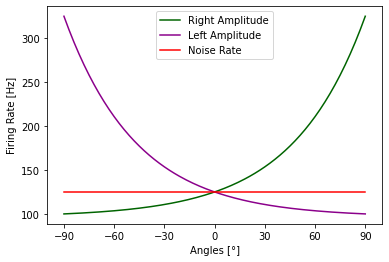

In [3]:
#New ILD: computed considering the input sound at -80 dB and max_ILD = |20 dB|
max_amp = 325 #Hz
min_amp = 100

def expfunc(x, a, b, c):
    return a + (b * np.exp(c * x))

p_opt_r, p_cov = scp.optimize.curve_fit(expfunc, [-90,0,90], [min_amp,mean_rate,max_amp], bounds = ([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
p_opt_l, p_cov = scp.optimize.curve_fit(expfunc, [-90,0,90], [max_amp,mean_rate,min_amp], bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

fig, ax = plt.subplots(1)
ax.set_xlim(-100,100)
ax.set_xlabel("Angles [°]")
ax.set_ylabel("Firing Rate [Hz]")
ax.set_xticks(np.linspace(-90,90,7))
x = np.linspace(-90,90,181)
ax.plot(x, expfunc(x, *p_opt_r),  color = 'darkgreen', label = "Right Amplitude")
ax.plot(x,expfunc(x, *p_opt_l), color = 'darkmagenta', label = "Left Amplitude")
ax.axhline(y = mean_rate, xmin = 0.05, xmax = 0.95, color = 'r', label = "Noise Rate")
ax.legend()

(0.0, 400.0)

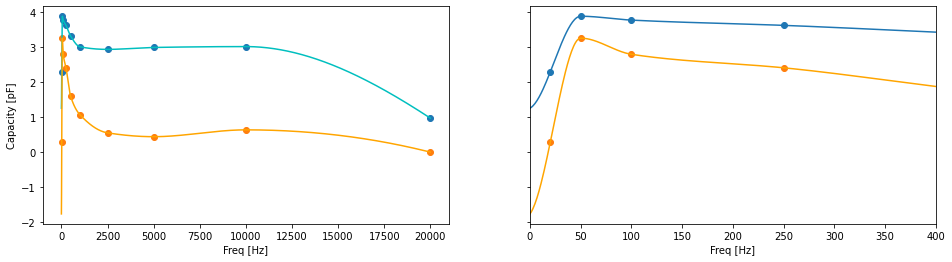

In [4]:
# New Capacities
caps_sbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results4/caps_sbc')
caps_gbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results4/caps_gbc')
cap_nuclei = 1 #pF

freqs = [20,50,100,250,500,1000,2500,5000,10000,20000]
eq_cap_sbc = scp.interpolate.PchipInterpolator(freqs, caps_sbc)
eq_cap_gbc = scp.interpolate.PchipInterpolator(freqs, caps_gbc)
#freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
#plt.plot(freq, pi(freq))
fig, ax = plt.subplots(1,2, figsize = (16,4), sharey = True)
ax[0].scatter(freqs,caps_sbc)
ax[0].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)), 'c')
ax[0].scatter(freqs,caps_gbc)
ax[0].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[0].set_xlabel("Freq [Hz]")
ax[0].set_ylabel("Capacity [pF]")
ax[1].scatter(freqs,caps_sbc)
ax[1].scatter(freqs,caps_gbc)
ax[1].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)))
ax[1].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[1].set_xlabel("Freq [Hz]")
ax[1].set_xlim([0,400])

In [5]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

ANFs2SBCs_weight = 2.0
ANFs2GBCs_weight = 1.0
GBCs2MNTBCs_weight = 16.0

SBCs2LSO_weight = 16.0
MNTBCs2LSO_weight = -2.0

SBCs2MSO_weight = 4.0
SBCs2MSO_inh_weight = -2.0
MNTBCs2MSO_weights = [0, -2.0, -4.0, -6.0, -8.0, -10.0, -12.0, -14.0, -16.0, -20.0]
n_battery = len(MNTBCs2MSO_weights)

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

In [6]:
#for C_m_bushy in caps:
    
    #rates = np.zeros((4,len(tones)))
    #nacs = np.zeros((4,len(tones)))
    
for tone in tones:
    
    C_m_scb = eq_cap_sbc(tone)
    C_m_gcb = eq_cap_gbc(tone)
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_LSO = np.zeros(len(angles))
    results_l_LSO = np.zeros(len(angles))

    results_r_SBC = np.zeros(len(angles))
    results_l_SBC = np.zeros(len(angles))

    results_r_GBC = np.zeros(len(angles))
    results_l_GBC = np.zeros(len(angles))
    
    for angle in angles:

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

        freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
        channel_x = np.where(freq>=tone)[0][0]
        spectro = np.zeros((3500,time_sim))
        amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)

        if(channel_x<10):
            #spectro[channel_x, :] = np.ones(time_sim)
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489):
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                #spectro[channel_x, :] = np.ones(time_sim)
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))

        delta_x = (w_head*np.sin(np.deg2rad(angle)))
        itd = 1000*delta_x/v_sound #ms
        ipds = 2*np.pi*itd*freq/1000

        # Populations

        r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

        l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
        params={'frequency': np.repeat(freq, 10),
            'phase': 0})


        r_ANFs = nest.Create('parrot_neuron', n_ANFs)

        l_ANFs = nest.Create('parrot_neuron',n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})


        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        r_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        l_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        ANFs_noise = nest.Create('poisson_generator',1,
                         params = {'rate':noise_rate})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')
        

        
        m_rec_r = nest.Create('multimeter', 1, {"record_from": ['V_m']})
        nest.SetStatus(m_rec_r, {'interval': 0.01})
        m_rec_l = nest.Create('multimeter', 1,  {"record_from": ['V_m']})
        nest.SetStatus(m_rec_l, {'interval': 0.01})
        
        # Connections

        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')
        nest.Connect(l_MSO, s_rec_l, 'all_to_all')

        nest.Connect(r_LSO, s_rec_r, 'all_to_all')
        nest.Connect(l_LSO, s_rec_l, 'all_to_all')
        
        nest.Connect(m_rec_r, r_MSO, 'all_to_all')
        nest.Connect(m_rec_l, l_MSO, 'all_to_all')


        for i in range(len(spectro)-1):
            if(np.any(spectro[i][:] > 0)):
                nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
                nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')

        for i in range(n_SBCs):
            nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

        for i in range(n_GBCs):
            nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})

        #MSO
        for i in range(n_GBCs):
            for j in range(n_battery):
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]})
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight, "delay": delays_mso[1]})
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]})
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]})
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight, "delay": delays_mso[1]})
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]})

        for i in range(n_GBCs):
            for j in range(n_battery):
                nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]})
                nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]})

        #LSO   
        for i in range(0, n_GBCs):
            nest.Connect(r_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
            nest.Connect(l_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})   

        nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
        nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})


        mean_amplitude_r = 325#expfunc(angle, *p_opt_r)
        mean_amplitude_l = 325#expfunc(angle, *p_opt_l)

        def input_set_up(spectro, ms): 
            for r in range(0, len(spectro)-1):
                if spectro[r][ms] > 0:
                    r_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
                    l_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
                    r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
                    l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

        for i in range(time_sim):
            input_set_up(spectro,i)
            nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')

        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')
        id_r_LSO1 = r_LSO[0].get('global_id')

        id_l_ANF1 = l_ANFs[0].get('global_id')
        id_l_SBC1 = l_SBCs[0].get('global_id')
        id_l_GBC1 = l_GBCs[0].get('global_id')
        id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
        id_l_MSO1 = l_MSO[0].get('global_id')
        id_l_LSO1 = l_LSO[0].get('global_id')


        # Active Cells
        ac_r_anf = np.unique(data_r['senders'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])
        ac_l_anf = np.unique(data_l['senders'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])

        ac_r_sbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])
        ac_l_sbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])

        ac_r_gbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])
        ac_l_gbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])

        ac_r_mntbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])
        ac_l_mntbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])


        # Global Rates
        rate_r_anf = len(data_r['times'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])*1000/time_sim
        rate_l_anf = len(data_l['times'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])*1000/time_sim

        rate_r_sbc = len(data_r['times'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])*1000/time_sim
        rate_l_sbc = len(data_l['times'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])*1000/time_sim

        rate_r_gbc = len(data_r['times'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])*1000/time_sim
        rate_l_gbc = len(data_l['times'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])*1000/time_sim

        rate_r_mntbc = len(data_r['times'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])*1000/time_sim
        rate_l_mntbc = len(data_l['times'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])*1000/time_sim


        #LSO

        #averaging on total number of active cells --> result: averege rate of the population
        rate_r_lso = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])/(time_sim)*1000
        rate_l_lso = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])/(time_sim)*1000

        ac_r_lso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_LSO1))])
        ac_l_lso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_LSO1))])


        #MSO

        #averaging on total number of active batteries --> result: battery with rates for each inh weight
        rate_r_mso = np.zeros(n_battery)
        rate_l_mso = np.zeros(n_battery)
        ac_r_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        ac_l_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        n_ac_r_mso = np.zeros(n_battery)
        n_ac_l_mso = np.zeros(n_battery)

        for i in range(int(n_MSOs/n_battery)): #n of batteries
            for j in range(n_battery): # neurons for battery
                if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                    rate_r_mso[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_r_mso[i,j] = id_r_MSO1 + i*n_battery + j
                    n_ac_r_mso[j] += 1
                else:
                    rate_r_mso[j] += 0
                if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                    rate_l_mso[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_l_mso[i,j] = id_l_MSO1 + i*n_battery + j
                    n_ac_l_mso[j] += 1
                else:
                    rate_l_mso[j] += 0     

    """"
        results_r_SBC[np.where(angles == angle)[0][0]] = rate_r_sbc
        results_l_SBC[np.where(angles == angle)[0][0]] = rate_l_sbc

        results_r_GBC[np.where(angles == angle)[0][0]] = rate_r_gbc
        results_l_GBC[np.where(angles == angle)[0][0]] = rate_l_gbc

        results_r_LSO[np.where(angles == angle)[0][0]] = rate_r_lso
        results_l_LSO[np.where(angles == angle)[0][0]] = rate_l_lso

        results_r_MSO[:, np.where(angles == angle)[0][0]] = rate_r_mso
        results_l_MSO[:, np.where(angles == angle)[0][0]] = rate_l_mso
        
    
    # for computing angle-tones simulations
    n_folder = 6
    
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/SBC_r_freq_{}'.format(n_folder,tone), results_r_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/SBC_l_freq_{}'.format(n_folder,tone), results_l_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/GBC_r_freq_{}'.format(n_folder,tone), results_r_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/GBC_l_freq_{}'.format(n_folder,tone), results_l_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_r_freq_{}'.format(n_folder,tone), results_r_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_l_freq_{}'.format(n_folder,tone), results_l_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_r_freq_{}'.format(n_folder,tone), results_r_LSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_l_freq_{}'.format(n_folder,tone), results_l_LSO)"""

    """"
    # for computing capacities (n_folder 4)
    rates[0,tones.index(tone)] = rate_r_sbc
    rates[1,tones.index(tone)] = rate_l_sbc
    rates[2,tones.index(tone)] = rate_r_gbc
    rates[3,tones.index(tone)] = rate_l_gbc

    nacs[0,tones.index(tone)] = len(ac_r_sbc)
    nacs[1,tones.index(tone)] = len(ac_l_sbc)
    nacs[2,tones.index(tone)] = len(ac_r_gbc)
    nacs[3,tones.index(tone)] = len(ac_l_gbc)

    n_folder = 3 #capacities every single tone (deleted)

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_gbc])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_gbc])


    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_gbc)])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_gbc)])


n_folder = 4

np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rates_C_{}'.format(n_folder,C_m_bushy), rates)
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nacs_C_{}'.format(n_folder,C_m_bushy), nacs)"""


Nov 11 17:55:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Nov 11 18:08:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1253080 nodes for simulation.

Nov 11 18:08:20 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Nov 11 18:08:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253080
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Nov 11 18:08:21 SimulationManager::run [Info]: 
    Simulation finished.

Nov 11 18:08:21 NodeManager::prepare_nodes [Info]: 
    Preparing 1253080 nodes

In [7]:
data_mso_r = m_rec_r.get('events')
data_mso_l = m_rec_l.get('events')

In [8]:
ac_r_mso

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
n_ac_r_mso

array([3., 3., 3., 2., 1., 1., 1., 1., 1., 1.])

In [10]:
n_ac_l_mso

array([3., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [11]:
np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MSO1)&(data_r['senders']<id_r_LSO1))],  return_counts= True)

(array([168561, 168562, 168563, 168564, 168565, 168566, 168567, 168568,
        168569, 168570, 168571, 168572, 168573, 168591, 168592, 168593,
        168594]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [12]:
np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MSO1)&(data_l['senders']<id_l_LSO1))])

array([186061, 186062, 186063, 186064, 186065, 186066, 186067, 186068,
       186069, 186070, 186071, 186091, 186092, 186093, 186094, 186095,
       186096, 186097, 186098, 186099, 186100])

In [13]:
ac_r_mso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MSO1)&(data_r['senders']<id_r_LSO1))])[0:4]
print(ac_r_mso)
ac_l_mso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MSO1)&(data_l['senders']<id_l_LSO1))])[0:4]
print(ac_l_mso)

[168561 168562 168563 168564]
[186061 186062 186063 186064]


In [14]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

---------
Neuron 0
[14.91] ms
---------
Neuron 1
[14.91] ms
---------
Neuron 2
[14.91] ms
---------
Neuron 3
[14.91] ms


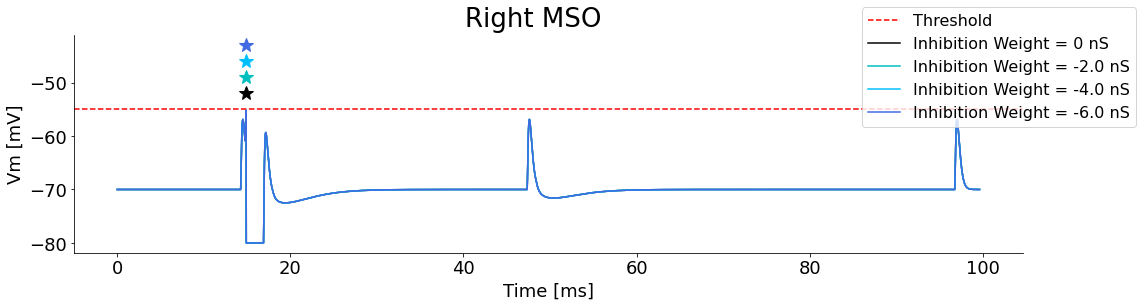

In [16]:
colors = ['k','c', 'deepskyblue', 'royalblue', 'darkblue']

fig, ax = plt.subplots(1, figsize=(17,4), sharey = True)

ax.axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")

for i in range(4):
    ax.plot(data_mso_r['times'][np.where(data_mso_r['senders'] == ac_r_mso[i])], data_mso_r['V_m'][np.where(data_mso_r['senders'] == ac_r_mso[i])],  color = colors[i], label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[i]))
    ax.plot(data_r['times'][np.where(data_r['senders'] == ac_r_mso[0]+i)],  (-52+3*i)*np.ones(len(data_r['times'][np.where(data_r['senders'] == ac_r_mso[0]+i)])), color = colors[i], marker = '*', ms = 14, linestyle = 'None')
    print("---------")
    print("Neuron", i)
    print(data_r['times'][np.where(data_r['senders'] == ac_r_mso[0]+i)], "ms")
        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
fig.suptitle("Right MSO")
fig.legend()

#ax.set_xlim(70,80)

---------
Neuron 0
[14.91] ms
---------
Neuron 1
[14.91] ms
---------
Neuron 2
[14.91] ms
---------
Neuron 3
[14.91] ms


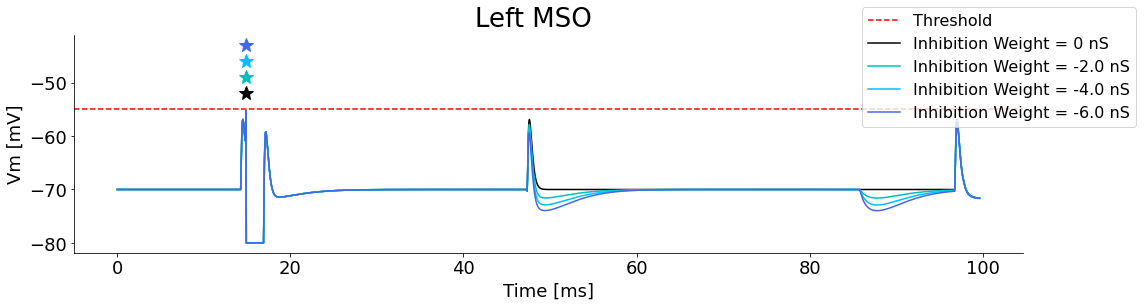

In [18]:
colors = ['k','c', 'deepskyblue', 'royalblue', 'darkblue']

fig, ax = plt.subplots(1, figsize=(17,4), sharey = True)

ax.axhline(y = l_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")

for i in range(4):
    ax.plot(data_mso_l['times'][np.where(data_mso_l['senders'] == ac_l_mso[i])], data_mso_l['V_m'][np.where(data_mso_l['senders'] == ac_l_mso[i])],  color = colors[i], label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[i]))
    ax.plot(data_l['times'][np.where(data_l['senders'] == ac_l_mso[0]+i)],  (-52+3*i)*np.ones(len(data_l['times'][np.where(data_l['senders'] == ac_l_mso[0]+i)])), color = colors[i], marker = '*', ms = 14, linestyle = 'None')
    print("---------")
    print("Neuron", i)
    print(data_l['times'][np.where(data_l['senders'] == ac_l_mso[0]+i)], "ms")
        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
fig.suptitle("Left MSO")
fig.legend()
#plt.savefig('demo.png', transparent=True)

In [24]:
r_MSO[0].get('V_m')

-70.0

# Computation of Calix Delay

In [19]:
data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]

array([159655, 159655, 159655, 159658, 159658, 159658, 159658, 159659,
       159659, 159659, 159659, 159659, 159660, 159660, 159661, 159661,
       159661, 159662])

In [20]:
data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))]

array([163155, 163155, 163155, 163158, 163158, 163158, 163158, 163159,
       163159, 163159, 163159, 163159, 163160, 163160, 163161, 163161,
       163161, 163162])

In [21]:
data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]

array([47.43, 76.76, 84.52,  5.  , 65.08, 84.24, 95.22,  3.69,  6.6 ,
       15.7 , 33.77, 74.85, 33.55, 43.27,  5.62, 15.85, 83.53, 83.7 ])

In [22]:
data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))]

array([47.94, 77.27, 85.03,  5.51, 65.59, 84.75, 95.73,  4.2 ,  7.11,
       16.21, 34.28, 75.36, 34.06, 43.78,  6.13, 16.36, 84.04, 84.21])

In [23]:
data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]

array([0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51,
       0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51])

In [25]:
data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))]

array([157906, 157907, 157907, 157908, 157908, 157908, 157909, 157909,
       157909, 157909, 157909, 157910, 157910, 157910, 157910, 157910,
       157910, 157911, 157911, 157912, 157913, 157913])

In [26]:
data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))]

array([161408, 161408, 161408, 161409, 161409, 161409, 161409, 161409,
       161410, 161410, 161410, 161410, 161410, 161410, 161411, 161411,
       161412, 161413, 161413, 161406, 161407, 161407])

In [27]:
data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))]

array([98.31, 46.34, 84.81, 14.31, 65.59, 95.5 , 14.97, 34.71, 55.19,
       63.67, 74.74,  4.46, 14.38, 23.67, 43.28, 53.87, 56.94, 26.13,
       34.6 , 13.65, 28.79, 94.06])

In [28]:
data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))]

array([14.82, 66.1 , 96.01, 15.48, 35.22, 55.7 , 64.18, 75.25,  4.97,
       14.89, 24.18, 43.79, 54.38, 57.45, 26.64, 35.11, 14.16, 29.3 ,
       94.57, 98.82, 46.85, 85.32])

In [29]:
times_r_gbc = data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))]
times_r_mntbc = data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))]
times_r_gbc.sort()
times_r_mntbc.sort()
print(times_r_mntbc-times_r_gbc)

[0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51
 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51]
